In [2]:
import os
from glob import glob
from PIL import Image
import math

import json
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
BASE_DIR = "../model_results/"
model_dirs = [os.path.join(BASE_DIR, d) for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d))]

In [4]:
def summarize_model_results(base_dir=BASE_DIR):
    summary = []
    for model_name in os.listdir(base_dir):
        model_dir = os.path.join(base_dir, model_name)
        if not os.path.isdir(model_dir):
            continue  # Skip files like .DS_Store
        metrics_file = os.path.join(model_dir, f"{model_name}_metrics.json")
        if os.path.exists(metrics_file):
            with open(metrics_file, "r") as f:
                data = json.load(f)
                if "valAcc" in data and "valLoss" in data:
                    max_val_acc = max(data["valAcc"])
                    min_val_loss = min(data["valLoss"])
                    summary.append({
                        "Model": model_name,
                        "Best Val Accuracy": max_val_acc,
                        "Min Val Loss": min_val_loss
                    })

    df = pd.DataFrame(summary)
    if not df.empty and "Best Val Accuracy" in df.columns:
        df.sort_values(by="Best Val Accuracy", ascending=False, inplace=True)
    else:
        print("No valid model results found or missing 'Best Val Accuracy' column.")
        print("DataFrame columns:", df.columns)
    df.to_csv(os.path.join(base_dir, "model_summary.csv"), index=False)
    print("\n📊 Model Performance Summary:")
    print(df)
    return df

In [5]:
df = summarize_model_results()


📊 Model Performance Summary:
             Model  Best Val Accuracy  Min Val Loss
2  efficientnet_b0          98.733108      0.043532
0         resnet50          98.564189      0.056349
1      densenet121          98.564189      0.048801
3        resnet101          98.479730      0.043416
4  efficientnet_b4          97.804054      0.064054


In [6]:
all_reports = []

for model_name in os.listdir(BASE_DIR):
    model_dir = os.path.join(BASE_DIR, model_name)
    if not os.path.isdir(model_dir):
        continue
    csv_path = os.path.join(model_dir, f"{model_name}_classification_report.csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path, index_col=0)
        # Add model name as a new level in the index
        df['Model'] = model_name
        df.set_index('Model', append=True, inplace=True)
        all_reports.append(df)

# Concatenate all DataFrames
if all_reports:
    combined = pd.concat(all_reports)
    # Swap index levels so Model is first, then metric
    combined = combined.reorder_levels(['Model', combined.index.names[0]])
    # Sort for neatness
    combined.sort_index(inplace=True)
    display(combined)
    #save to csv
    combined.to_csv('../model_results/All_model_results.csv')
else:
    print("No classification reports found.")

precision    recall  f1-score      support
Model                                                                   
densenet121     Normal         0.979960  0.962598  0.971202   508.000000
                Pneumonia      0.958904  0.983607  0.971098   427.000000
                TB             0.997118  0.991404  0.994253   349.000000
                accuracy       0.977414  0.977414  0.977414     0.977414
                macro avg      0.978661  0.979203  0.978851  1284.000000
                weighted avg   0.977621  0.977414  0.977433  1284.000000
efficientnet_b0 Normal         0.981855  0.958661  0.970120   508.000000
                Pneumonia      0.969977  0.983607  0.976744   427.000000
                TB             0.977465  0.994269  0.985795   349.000000
                accuracy       0.976636  0.976636  0.976636     0.976636
                macro avg      0.976432  0.978846  0.977553  1284.000000
                weighted avg   0.976712  0.976636  0.976583  1284.000000
efficientnet_b4 Normal         0.971888  0.952756  0.962227   508.000000
                Pneumonia      0.963134  0.978923  0.970964   427.000000
                TB             0.974432  0.982808  0.978602   349.000000
                accuracy       0.969626  0.969626  0.969626     0.969626
                macro avg      0.969818  0.971496  0.970598  1284.000000
                weighted avg   0.969668  0.969626  0.969583  1284.000000
resnet101       Normal         0.989540  0.931102  0.959432   508.000000
                Pneumonia      0.933628  0.988290  0.960182   427.000000
                TB             0.985876  1.000000  0.992888   349.000000
                accuracy       0.968847  0.968847  0.968847     0.968847
                macro avg      0.969681  0.973131  0.970834  1284.000000
                weighted avg   0.969950  0.968847  0.968775  1284.000000
resnet50        Normal         0.987805  0.956693  0.972000   508.000000
                Pneumonia      0.954649  0.985948  0.970046   427.000000
                TB             0.994302  1.000000  0.997143   349.000000
                accuracy       0.978193  0.978193  0.978193     0.978193
                macro avg      0.978918  0.980880  0.979730  1284.000000
                weighted avg   0.978545  0.978193  0.978184  1284.000000

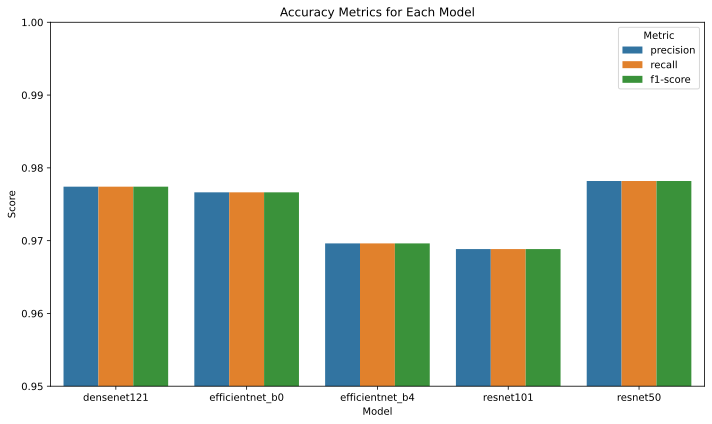

In [7]:
accuracy_df = combined.xs('accuracy', level=1)

# Reset index to get model names as a column
accuracy_df = accuracy_df.reset_index()

# Melt the DataFrame to long format for seaborn
melted = accuracy_df.melt(id_vars='Model', value_vars=['precision', 'recall', 'f1-score'],
                          var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Model', y='Score', hue='Metric')
plt.title('Accuracy Metrics for Each Model')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0.95, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig('../model_results/All_model_metrics.svg')
plt.show()

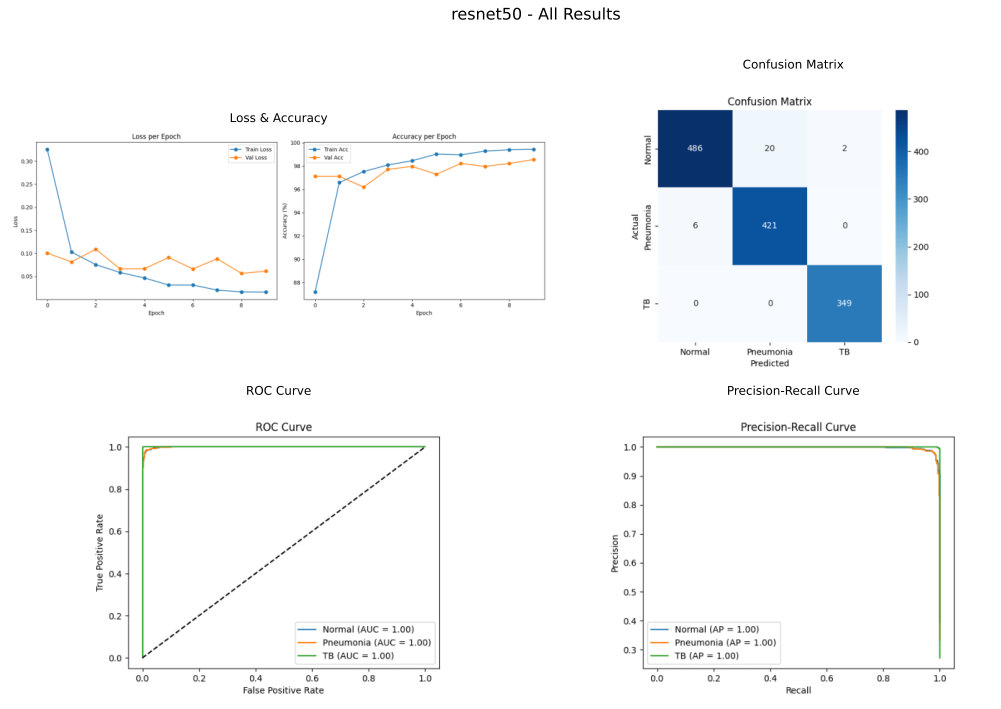

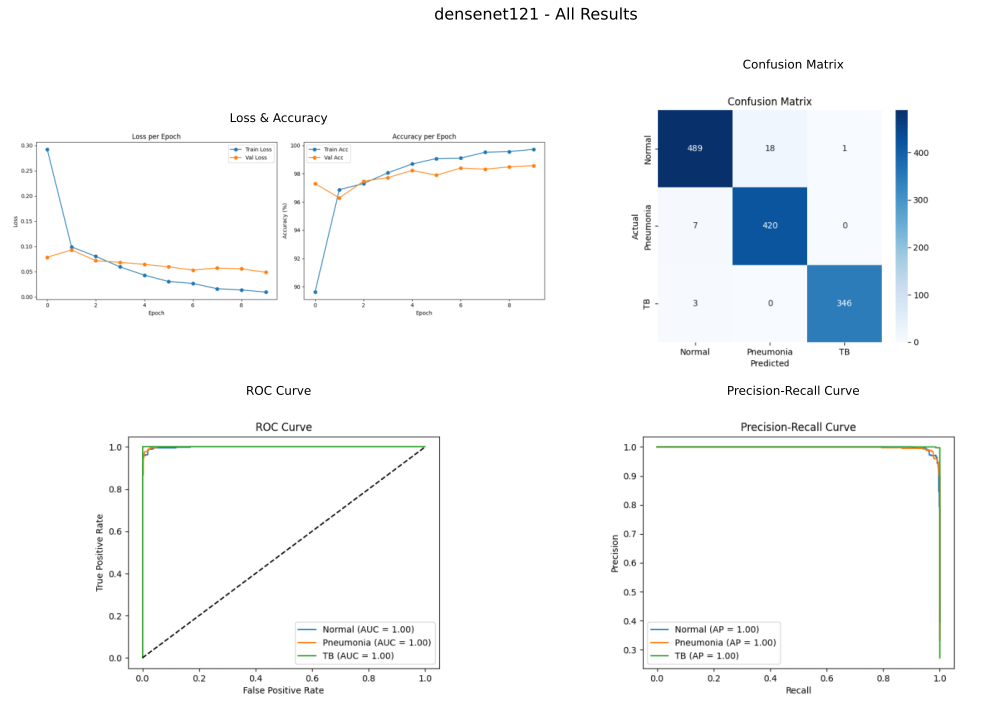

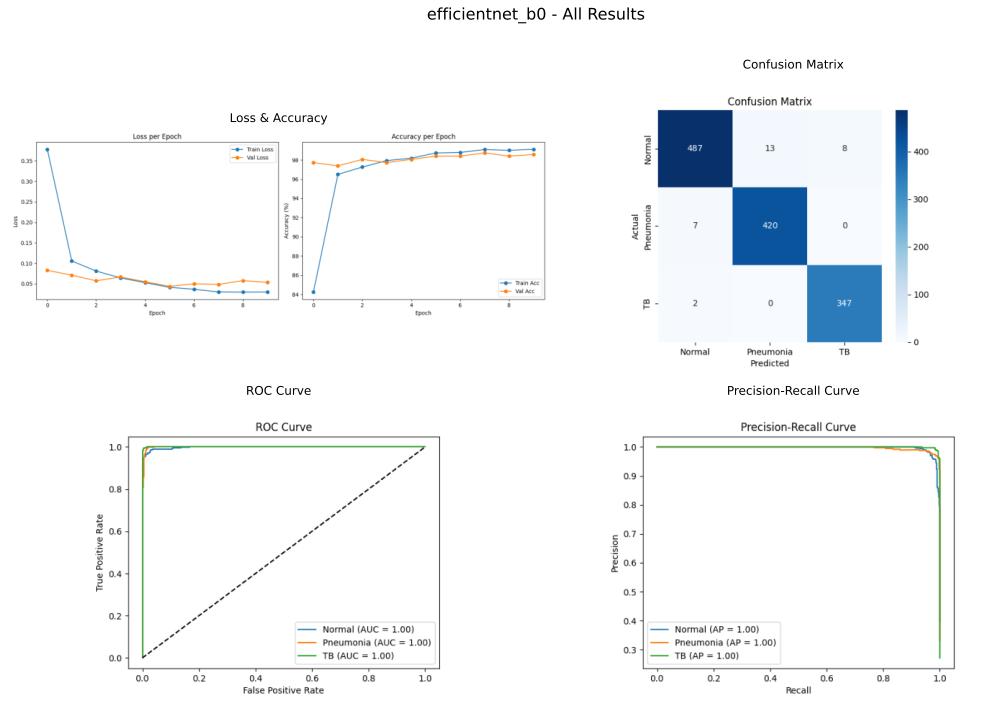

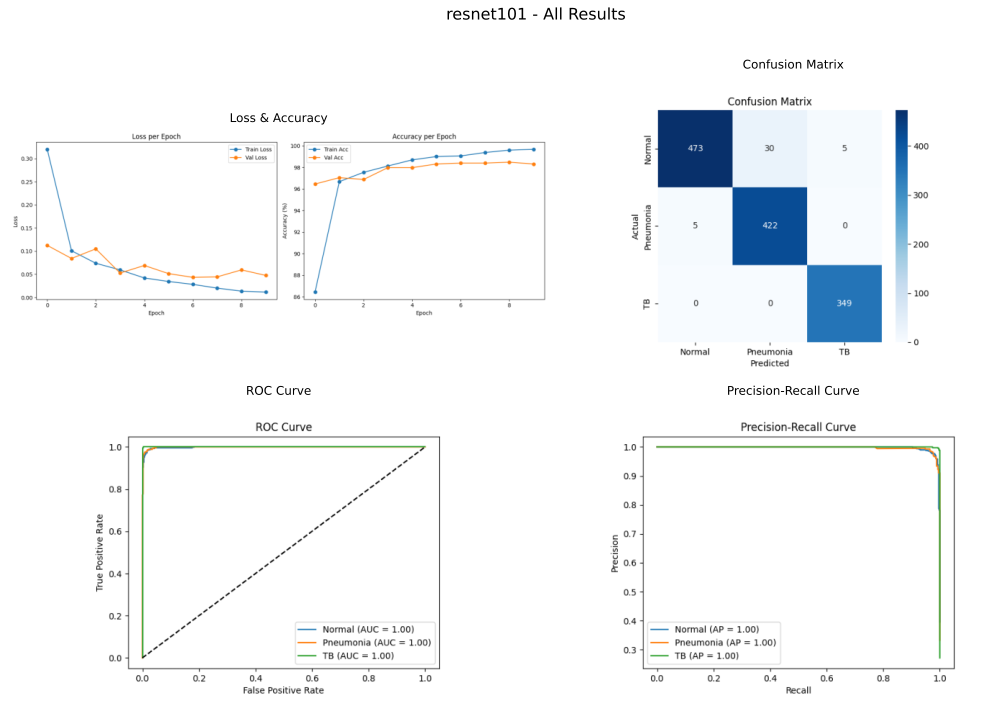

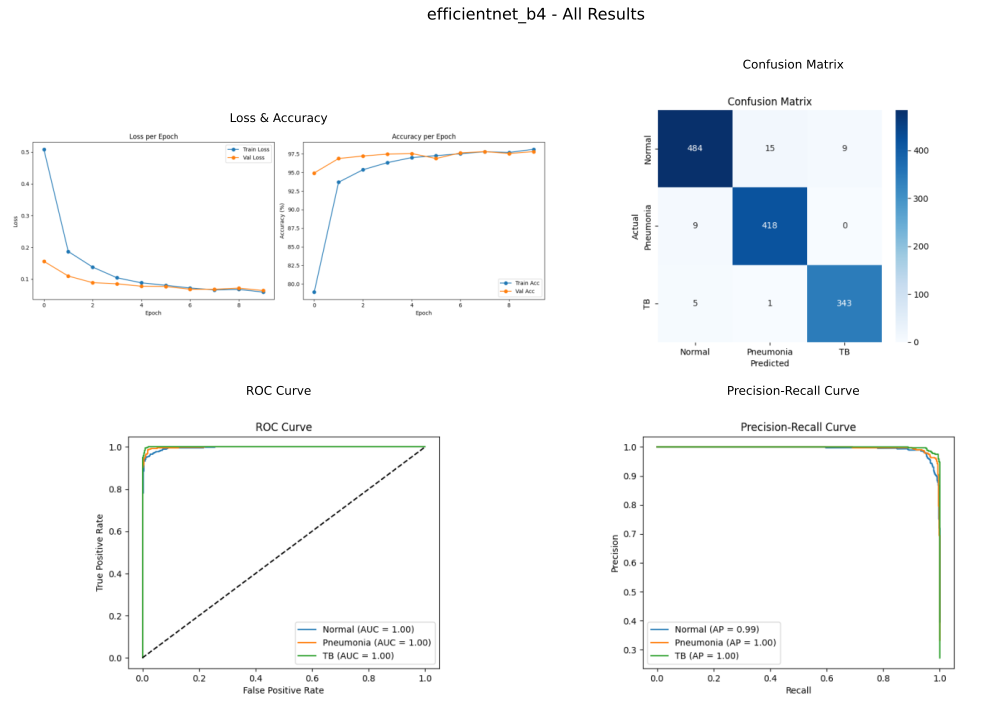

In [8]:
for model_dir in model_dirs:
    model_name = os.path.basename(model_dir)
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"{model_name} - All Results", fontsize=16)
    plot_types = [
        ("*_loss_accuracy.png", "Loss & Accuracy"),
        ("*_confusion_matrix.png", "Confusion Matrix"),
        ("*_roc_curve.png", "ROC Curve"),
        ("*_precision_recall_curve.png", "Precision-Recall Curve")
    ]
    for ax, (pattern, title) in zip(axs.flatten(), plot_types):
        img_path = glob(os.path.join(model_dir, pattern))
        if img_path:
            img = Image.open(img_path[0])
            ax.imshow(img)
            ax.set_title(title)
        ax.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()